In [12]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import main.packages.mine_generic as mine_g
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
hicp_all_path = 'data/preprocessed/hicp_yoy.csv'
hicp_class_path = 'data/HICP_COICOP10s.xlsx'
model = 'rf'
date_range = pd.date_range(start=mine_g.train_test_split_date + pd.DateOffset(months=1), end=mine_g.max_X_date, freq='M')


In [3]:

cat_short = 'food'
hicp_cat_path = f'data/preprocessed/{cat_short}_yoy_infl.csv'
category = 'Food'
save_cat_file_path = f'data/forecast_results/{cat_short}_forecast.csv'

HICP_monthly, HICP_class, HICP_cat = mine_g.import_data_all(hicp_all_path=hicp_all_path,
                                                     hicp_class_path=hicp_class_path,
                                                     hicp_cat_path=hicp_cat_path)

cat_df = mine_g.split_into_category(category=category,
                             HICP_class=HICP_class,
                             HICP_monthly=HICP_monthly)

Number of items in Food group:  180


/Users/lananhnguyen/Desktop/thesis/thesis_code/main/packages/mine_generic.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df.fillna(0, inplace=True)


In [4]:
# Create lag features
def create_lag_features(df, n_lags):
    new_df = df.rename(columns = {"yoy_rate": "lag_1"})

    for lag in range(1, n_lags + 1):
        new_df[f'lag_{lag+1}'] = new_df.loc[:, "lag_1"].shift(lag)
    return new_df

n_lags = 11
y_lagged = create_lag_features(HICP_cat.copy(), n_lags)

# Combine lagged values and additional predictors
X_with_lags = pd.concat([y_lagged, cat_df], axis= 1)
X_with_lags.dropna(inplace=True)

y = HICP_cat[HICP_cat.index.isin(X_with_lags.index)]

In [5]:
horizon = 1
X_train, X_test, y_train, y_test = mine_g.split_train_test_set(X = X_with_lags, y = y, h = horizon)


Horizon: 1
Training predictor period: 1997-12-31 00:00:00 to 2015-11-30 00:00:00
Training dependent variable period: 1998-01-31 00:00:00 to 2015-12-31 00:00:00


In [6]:
# Define TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Define RandomForestRegressor and parameter grid for hyperparameter tuning
rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [1000],
    'max_depth': np.arange(2, 8, 1),
    "n_jobs": [-1],
    "random_state": [1],
    'bootstrap': [True],
    'max_samples': [0.5, 0.75, 1.0]  # 50%, 75%, and 100% of samples if bootstrap=True

}
# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train.iloc[:, 0])

# Best model
best_rf = grid_search.best_estimator_

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", -grid_search.best_score_)


Best Parameters: {'bootstrap': True, 'max_depth': 5, 'max_samples': 1.0, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 1}
Best CV Score: 1.4934985799974185


In [7]:
# Forecast:
def generate_forecast(X, N, T, h, verbose=1): # from common function
    """
    Generate recursive forecast
    """
    print(f"Horizon: {h}")
    print("------------------------")
    y_pred_series = []
    for i in range(0, T):  # T+1-h
        # X_train = X.iloc[: N+i, :]
        # y_train = y.iloc[h: N+i+h, :]

        X_test_here = X.iloc[N+i : N+i+1, :] 
        # y_test = y.iloc[N+i+h : N+i+h+1, :]  

        if X_test_here.index[-1] > X.index[-1]-pd.DateOffset(months=h):
            break

        # Forecast:
        next_pred = best_rf.predict(X_test_here)
    
        if verbose == 1:
            print(f"Training period - features: {X_train.index[0]} to {X_train.index[-1]}")
            print(f"Training period - target : {y_train.index[0]} to {y_train.index[-1]}")
            print(f"Test period - features: {X_test.index}")
            print(f"Test period - target : {y_test.index}")
            print(f"Forecast: {next_pred}")
            print("-------------------------------------------------------")

        y_pred_series.append(next_pred[0])
    return y_pred_series

In [9]:
# Forecast:

N, T = len(X_train), len(X_test)
y_pred = generate_forecast(X = X_with_lags, N = N, T = T, h = horizon, verbose=0)
# food_cat_prediction.loc[:, f'{model}_{cat_short}_h_{h}'] = y_pred
y_pred

Horizon: 1
------------------------


[1.5384588992100554,
 1.4663741613238757,
 1.3707248685706033,
 1.443350462564873,
 1.368833064988354,
 1.1581815521379912,
 1.0778764865767605,
 1.5559919143618444,
 1.3773960159920307,
 1.3841342726086028,
 1.2803788555699784,
 1.62038629725384,
 2.1855210967300214,
 2.810025937618933,
 2.918017468967296,
 2.263035498326484,
 1.8548567659322956,
 2.3640183802329693,
 2.7578594318796124,
 2.414619276408122,
 2.864555532008599,
 2.839254460859099,
 2.966306006988502,
 2.7072400457465298,
 2.743945079969718,
 2.7703882347172155,
 1.5319005562008605,
 2.8464688397965663,
 2.9162961830216294,
 2.963099497831915,
 2.9794278082001795,
 2.936354486393967,
 2.361644568545692,
 2.9437427349266643,
 2.311217287162737,
 2.2657514206194205,
 1.5726830640104146,
 1.188953696072294,
 1.4809875820401837,
 1.3181486590771643,
 1.0969203517987507,
 1.4530413782700289,
 1.494241793320405,
 1.7566036406282945,
 2.519678826834376,
 1.4935431986298768,
 1.5115682112916988,
 1.7355913269295833,
 2.32567546

In [11]:
yoy_real = pd.read_csv(f"data/preprocessed/{cat_short}_yoy_infl.csv", parse_dates=True, index_col='date')
yoy_real_test = yoy_real[(yoy_real.index > mine_g.train_test_split_date) & (yoy_real.index <= mine_g.max_X_date)]


print(mean_absolute_error(yoy_real_test, y_pred))
print(np.sqrt(mean_squared_error(yoy_real_test, y_pred)))

1.3337619028151022
2.9416234026616936


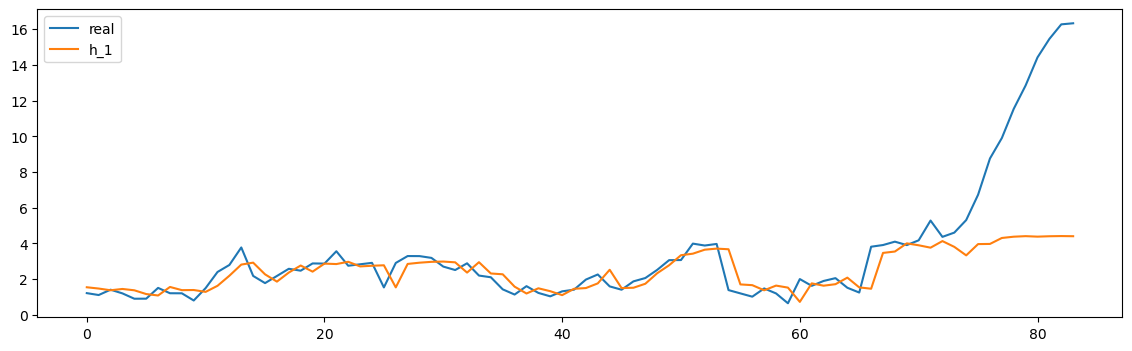

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(yoy_real_test.reset_index(drop=True), label = "real")

plt.plot(y_pred, label = "h_1")
plt.legend()
plt.show()